In [1]:
target_size = (224,224)                                                                                                                                                                                                                                   
batch_size = 32
train_val_split = 0.2
num_classes = 5
nb_epochs =10
#init_epoch = 29
wandb_resume_state = True
exp_name = 'test5'

In [2]:
import shutil
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from keras.models import save_model
import cv2
from tensorflow.keras.metrics import AUC, Precision, Recall
import wandb
from wandb.keras import WandbCallback

In [3]:
train = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
#train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=train_val_split)
train_data_gen = ImageDataGenerator(rescale = 1./255,
                                    validation_split=train_val_split)
train_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/customdataset/Feature_Extraction', target_size = (224,224), batch_size = 20, class_mode = 'categorical', subset='training') 
validation_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/customdataset/Feature_Extraction', target_size = (224,224), batch_size = 20,  class_mode = 'categorical', subset='validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [5]:
labels = list(train_generator.class_indices.keys())

In [6]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf

class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        
        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out
class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [7]:
model = ResNet18(5)
model.build(input_shape = (None,224,224,3))
#use categorical_crossentropy since the label is one-hot encoded
#from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy",Precision(),  Recall(), AUC()])

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [8]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping( patience=3, verbose=1)

In [9]:
history = model.fit(train_generator,steps_per_epoch = len(train_generator),
                          validation_data = validation_generator,
                          validation_steps =len( validation_generator),epochs = nb_epochs ,callbacks=[early_stopping])

Epoch 1/10
147/147 [==============================] - 37s 178ms/step - loss: 0.9952 - accuracy: 0.6858 - precision: 0.7577 - recall: 0.6124 - auc: 0.8937 - val_loss: 1.8423 - val_accuracy: 0.3475 - val_precision: 0.3447 - val_recall: 0.3187 - val_auc: 0.7235
Epoch 2/10
147/147 [==============================] - 20s 132ms/step - loss: 0.7665 - accuracy: 0.7311 - precision: 0.8051 - recall: 0.6441 - auc: 0.9260 - val_loss: 0.9092 - val_accuracy: 0.6566 - val_precision: 0.8290 - val_recall: 0.4774 - val_auc: 0.8971
Epoch 3/10
147/147 [==============================] - 19s 132ms/step - loss: 0.7235 - accuracy: 0.7417 - precision: 0.8121 - recall: 0.6650 - auc: 0.9345 - val_loss: 1.8219 - val_accuracy: 0.3680 - val_precision: 0.4364 - val_recall: 0.2818 - val_auc: 0.6893
Epoch 4/10
147/147 [==============================] - 19s 131ms/step - loss: 0.6482 - accuracy: 0.7584 - precision: 0.8269 - recall: 0.6909 - auc: 0.9471 - val_loss: 1.0786 - val_accuracy: 0.6744 - val_precision: 0.7051 - v

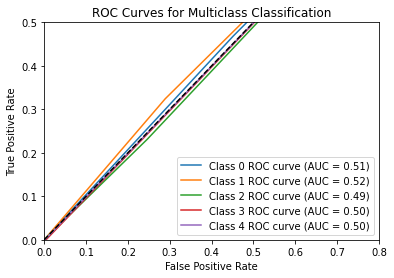

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error,mean_absolute_error
import numpy as np
# Make predictions for the test set
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred,axis=1)
y_true = validation_generator.classes

# Binarize the true labels and predictions
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_true))

# Compute the AUC for each class
aucs = []
for i in range(y_true_bin.shape[1]):
    fpr, tpr, thresholds = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    auc = roc_auc_score(y_true_bin[:, i], y_pred_bin[:, i])
    aucs.append(auc)
    plt.plot(fpr, tpr, label='Class {} ROC curve (AUC = {:.2f})'.format(i, auc))

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlim([0.0, 0.8])
plt.ylim([0.0, 0.5])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()


In [11]:
y_true = np.argmax(y_true_bin, axis=1)
y_pred = np.argmax(y_pred_bin, axis=1)


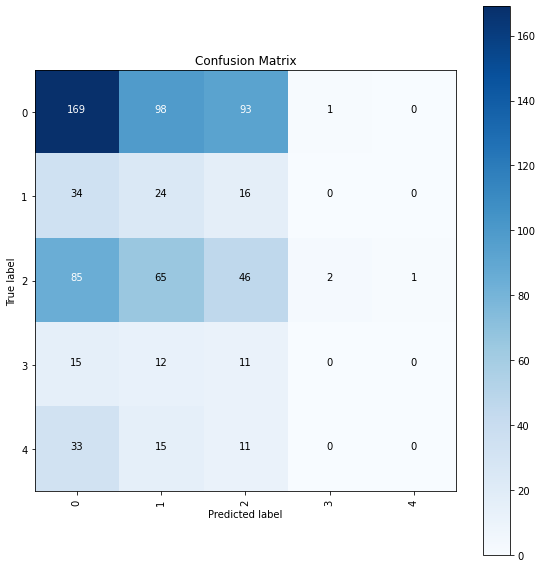

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

# Generate predictions for the test set
#y_pred = model.predict(validation_generator)
#y_pred = np.argmax(y_pred,axis=1)
#y_true = validation_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
class_names = validation_generator.class_indices.keys()

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [13]:
#save model
model_json = model.to_json()
with open('model_resnet18.json', 'w') as json_file:
    json_file.write(model_json)

model_saved = save_model(model, './weights.hdf5')
#load model
with open('model_resnet18.json', 'r') as json_file:
    json_saved_model = json_file.read()

model_loaded = tf.keras.models.model_from_json(json_saved_model)
model_loaded.load_weights('weights.hdf5')
model_loaded.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#test single image
path = '/kaggle/input/traindata/train/3/0104b032c141.png'
image = cv2.imread(path)
image = cv2.resize(image, (224,224))
image = image/ 255    #normalise
#print(image.shape)
image = image.reshape(-1, 224,224,3)      #reshape in format to send more than one image to predict
#print(image.shape)

result = model_loaded(image)
#print(result)  #probabilities that the image belong to each class
result = np.argmax(result, axis=1)

if(result==0):
    print('Grade 0')
elif(result == 1):
    print('Grade 1')
elif(result == 2):
    print('Grade 2')
elif(result == 3):
    print('Grade 3')
else:
    print('Grade 4')

NotImplementedError: 

In [14]:
#train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=train_val_split)
train_data_gen = ImageDataGenerator(rescale = 1./255,
                                    validation_split=train_val_split)
r_train_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/redlesion-customdataset/RedLesion_CustomDataset', target_size = (224,224), batch_size = 20, class_mode = 'categorical', subset='training') 
r_validation_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/redlesion-customdataset/RedLesion_CustomDataset', target_size = (224,224), batch_size = 20,  class_mode = 'categorical', subset='validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [15]:
history = model.fit(r_train_generator,steps_per_epoch = len(r_train_generator),
                          validation_data = r_validation_generator,
                          validation_steps =len( r_validation_generator),epochs = nb_epochs ,callbacks=[early_stopping])

Epoch 1/10
147/147 [==============================] - 400s 3s/step - loss: 0.9255 - accuracy: 0.6694 - precision: 0.7480 - recall: 0.5773 - auc: 0.8929 - val_loss: 8.2361 - val_accuracy: 0.1450 - val_precision: 0.1833 - val_recall: 0.0629 - val_auc: 0.4007
Epoch 2/10
147/147 [==============================] - 354s 2s/step - loss: 0.6876 - accuracy: 0.7410 - precision: 0.8015 - recall: 0.6762 - auc: 0.9406 - val_loss: 1.8528 - val_accuracy: 0.4309 - val_precision: 0.4981 - val_recall: 0.3653 - val_auc: 0.7075
Epoch 3/10
147/147 [==============================] - 354s 2s/step - loss: 0.4173 - accuracy: 0.8400 - precision: 0.8683 - recall: 0.8076 - auc: 0.9770 - val_loss: 1.3869 - val_accuracy: 0.5540 - val_precision: 0.5630 - val_recall: 0.5321 - val_auc: 0.8410
Epoch 5/10
147/147 [==============================] - 349s 2s/step - loss: 0.3265 - accuracy: 0.8908 - precision: 0.9063 - recall: 0.8676 - auc: 0.9853 - val_loss: 1.3751 - val_accuracy: 0.7196 - val_precision: 0.7242 - val_recal